In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# tp atr - 4, 6
# sl atr - 3, 5
# sl - Close, Low

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1651366861000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
sl_atr = 0.4
tp_atr = 12
kd_dir = 'Any'

In [6]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [7]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low      Volume
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.6520
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.8237
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.8878
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.3607
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.4383
...                    ...      ...      ...      ...      ...         ...
32737  2023-04-07 10:59:59  1871.76  1873.71  1875.24  1868.69   3541.9202
32738  2023-04-07 11:14:59  1873.72  1875.31  1875.87  1873.52   2698.0404
32739  2023-04-07 11:29:59  1875.31  1874.90  1877.03  1874.17   1823.1148
32740  2023-04-07 11:44:59  1874.89  1878.09  1878.16  1873.73   2462.7382
32741  2023-04-07 11:59:59  1878.09  1877.08  1878.54  1877.08    547.2465

[32742 rows x 6 columns]


In [8]:
df = rawdf.copy()

In [9]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [10]:
indicators(df, kd_dir)
print(df)

                Close_Time     Open    Close     High      Low      Volume  \
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.6520   
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.8237   
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.8878   
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.3607   
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.4383   
...                    ...      ...      ...      ...      ...         ...   
32737  2023-04-07 10:59:59  1871.76  1873.71  1875.24  1868.69   3541.9202   
32738  2023-04-07 11:14:59  1873.72  1875.31  1875.87  1873.52   2698.0404   
32739  2023-04-07 11:29:59  1875.31  1874.90  1877.03  1874.17   1823.1148   
32740  2023-04-07 11:44:59  1874.89  1878.09  1878.16  1873.73   2462.7382   
32741  2023-04-07 11:59:59  1878.09  1877.08  1878.54  1877.08    547.2465   

             ema_8       ema_18       ema_38         bb_u      

In [11]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] >= df['ema_38']


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [12]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,bb_u,...,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2022-05-01 09:29:59,2738.40,2738.36,2742.95,2734.26,3623.6520,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2022-05-01 09:44:59,2738.36,2768.97,2772.00,2725.40,11211.8237,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2022-05-01 09:59:59,2768.97,2770.25,2777.36,2762.01,9232.8878,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2022-05-01 10:14:59,2770.26,2773.27,2776.22,2765.86,4203.3607,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2022-05-01 10:29:59,2773.27,2771.35,2780.62,2769.65,5154.4383,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32737,2023-04-07 10:59:59,1871.76,1873.71,1875.24,1868.69,3541.9202,1874.556542,1873.999182,1873.370042,1881.511473,...,50.396391,46.417821,38.856795,True,True,False,True,True,False,False
32738,2023-04-07 11:14:59,1873.72,1875.31,1875.87,1873.52,2698.0404,1874.723977,1874.137163,1873.469527,1881.685113,...,53.017499,56.050572,45.715432,False,False,True,True,True,False,False
32739,2023-04-07 11:29:59,1875.31,1874.90,1877.03,1874.17,1823.1148,1874.763093,1874.217462,1873.542885,1881.849750,...,52.255504,53.582179,52.016857,False,False,True,True,True,False,False
32740,2023-04-07 11:44:59,1874.89,1878.09,1878.16,1873.73,2462.7382,1875.502406,1874.625097,1873.776070,1882.262560,...,57.387238,72.787477,60.806743,False,False,True,True,True,False,False


In [13]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                Close_Time     Open    Close     High      Low      Volume  \
57     2022-05-01 23:44:59  2797.30  2791.49  2803.60  2788.30   7538.8782   
58     2022-05-01 23:59:59  2791.48  2805.75  2819.31  2786.10  12415.3549   
59     2022-05-02 00:14:59  2805.76  2818.67  2828.93  2801.53  11179.1883   
60     2022-05-02 00:29:59  2818.66  2817.01  2827.28  2816.00   6848.9254   
62     2022-05-02 00:59:59  2821.41  2812.20  2825.38  2811.76   3479.0461   
...                    ...      ...      ...      ...      ...         ...   
32628  2023-04-06 07:44:59  1910.20  1911.21  1912.90  1910.02   1536.1246   
32630  2023-04-06 08:14:59  1908.68  1899.84  1909.91  1897.00   8554.7243   
32730  2023-04-07 09:14:59  1881.77  1881.35  1882.61  1879.16   3120.4279   
32731  2023-04-07 09:29:59  1881.34  1878.02  1881.35  1876.37   2716.3353   
32732  2023-04-07 09:44:59  1878.02  1877.41  1878.81  1875.05   2364.3915   

             ema_8       ema_18       ema_38         bb_u  ... 

In [14]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


     Profit      Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  10896.29  6092.24     1318.67   -107.94         17       27441.7  397.07%   

  Win_Rate  
0   20.49%  

               Close_Time     Open    Close     High      Low        ema_8  \
0     2022-05-01 23:59:59  2791.48  2805.75  2819.31  2786.10  2782.363206   
1     2022-05-02 00:29:59  2818.66  2817.01  2827.28  2816.00  2796.337742   
2     2022-05-02 00:59:59  2821.41  2812.20  2825.38  2811.76  2804.196165   
3     2022-05-02 01:14:59  2812.21  2818.15  2819.96  2811.12  2807.297017   
4     2022-05-02 01:29:59  2818.16  2812.14  2818.16  2804.01  2808.373235   
...                   ...      ...      ...      ...      ...          ...   
5297  2023-04-06 06:29:59  1908.99  1907.34  1909.17  1907.14  1908.298499   
5298  2023-04-06 07:44:59  1910.20  1911.21  1912.90  1910.02  1909.739103   
5299  2023-04-06 08:14:59  1908.68  1899.84  1909.91  1897.00  1907.357976   
5300  2023-04-07 09:29:59  1881.

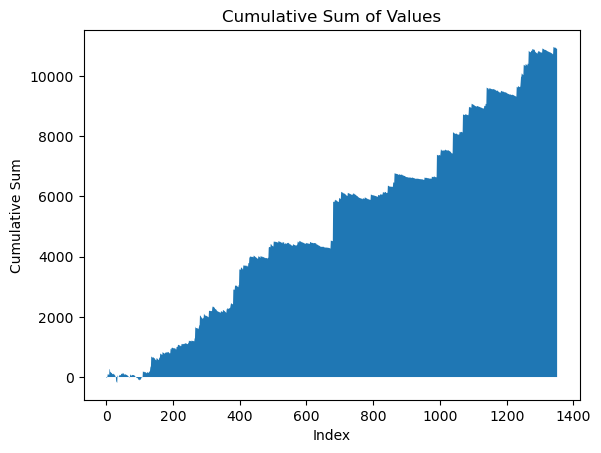

[10.40862660000065, -20.017965849999698, -33.21749074999941, -15.295985899998794, 42.28454925000523, 101.02215335000358, 92.2160131500035, 80.78284175000324, 73.88710600000292, 67.73194090000302, 267.47533545000215, 259.20998055000206, 170.56164050000385, 162.88946445000394, 155.59562830000422, 140.3501943000049, 134.19320265000476, 128.30285445000487, 104.74509780000488, 98.83079850000452, 93.28299885000436, 85.72673045000445, 114.41443700000563, 101.63440995000524, 89.82689350000543, 70.71483170000732, 58.54284725000706, 45.904633400006986, 10.028932950006997, -18.45592274999239, -138.49635459999482, -160.00461399999472, -180.74396679999472, -195.38495669999463, 48.59995265000458, 43.45345360000488, 8.686754050005845, 0.2695539000059899, -7.831198799994185, 59.4423744000063, 46.74763740000695, 74.63327830000559, 67.48195645000597, 60.13089065000536, 52.84623000000523, 113.52843375000954, 105.91662315000983, 101.51714940001031, 93.56811455001024, 114.87717080001119, 137.68107580001202

In [15]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

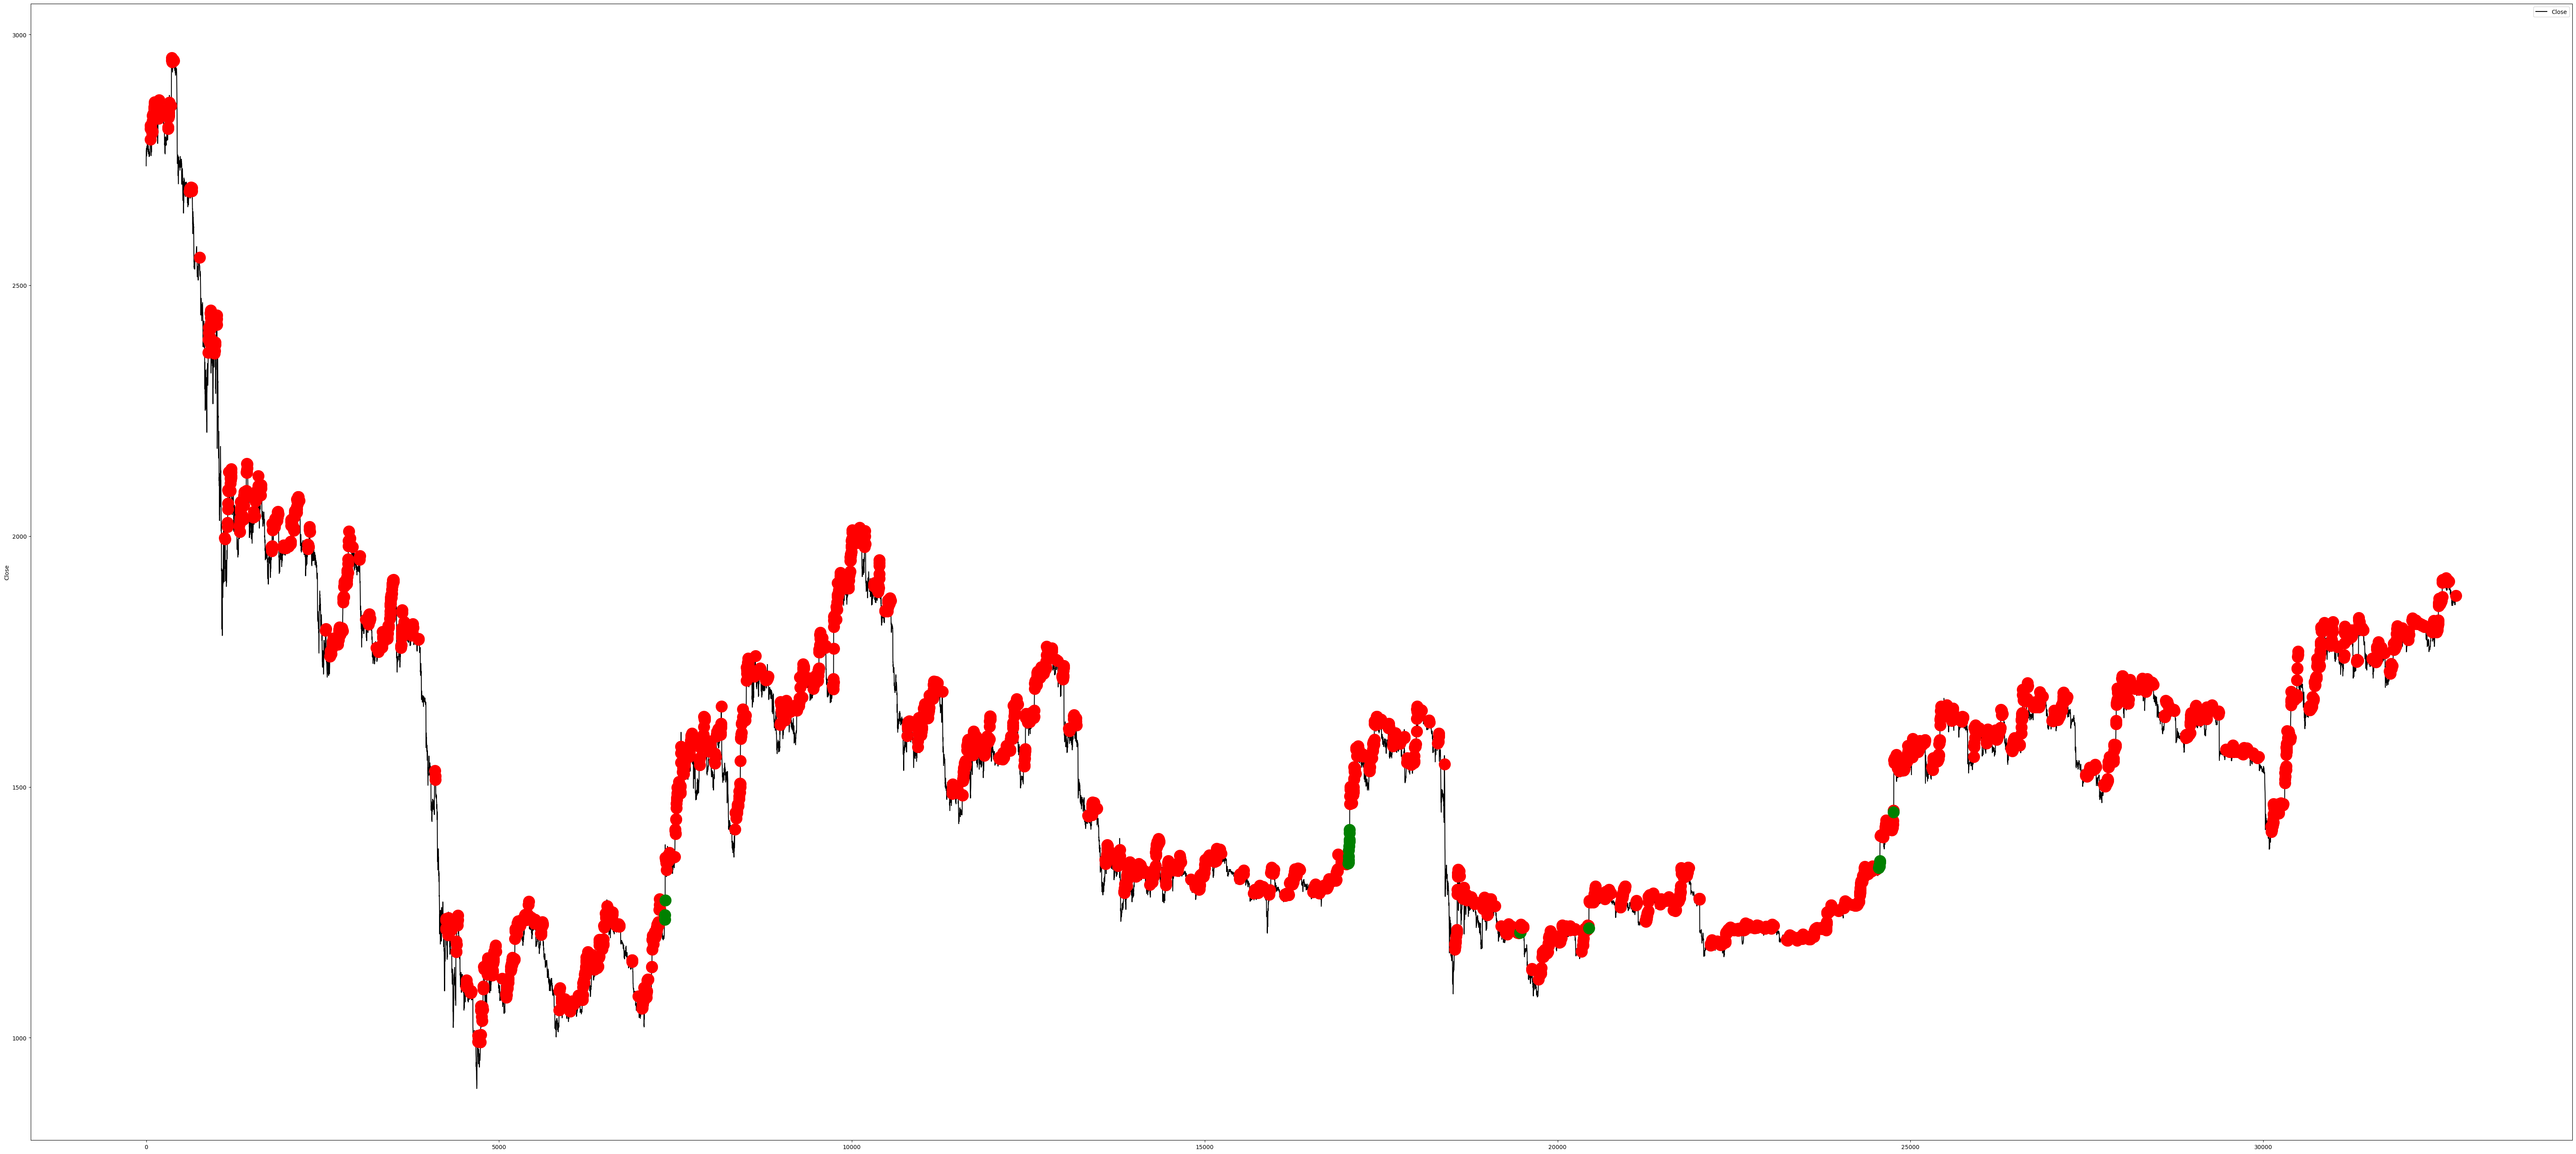

In [16]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位